In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import random
from pathlib import Path
from tqdm import tqdm

# CONFIGURATION
SOURCE_DIR = "/kaggle/input/deepfake-celebdf"
FRAME_EVERY_N = 10  # extract every 10th frame
NUM_REAL_VIDEOS = 5
NUM_FAKE_VIDEOS = 5
OUTPUT_DIR = "/kaggle/working/data"

# CREATE OUTPUT FOLDERS
os.makedirs(f"{OUTPUT_DIR}/real", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/fake", exist_ok=True)

def get_video_paths(folder_path, limit):
    all_files = list(Path(folder_path).glob("*.mp4"))
    return random.sample(all_files, limit)

# SELECT VIDEOS
real_videos = get_video_paths(f"{SOURCE_DIR}/Celeb-real", NUM_REAL_VIDEOS)
fake_videos = get_video_paths(f"{SOURCE_DIR}/Celeb-synthesis", NUM_FAKE_VIDEOS)

print("📁 Selected Real Videos:")
for v in real_videos: print(f"  - {v.name}")
print("\n📁 Selected Fake Videos:")
for v in fake_videos: print(f"  - {v.name}")

# FUNCTION TO EXTRACT FRAMES
def extract_frames(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    video_name = video_path.stem
    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % FRAME_EVERY_N == 0:
            filename = f"{video_name}_frame{frame_count:03d}.jpg"
            out_path = os.path.join(OUTPUT_DIR, label, filename)
            cv2.imwrite(out_path, frame)
            saved_count += 1
        frame_count += 1
    cap.release()
    print(f"✅ Extracted {saved_count} frames from {video_name} ({label})")

# RUN EXTRACTION
print("\n🚀 Starting frame extraction...\n")
for video in tqdm(real_videos, desc="📽️ Real Videos"):
    extract_frames(video, "real")

for video in tqdm(fake_videos, desc="📽️ Fake Videos"):
    extract_frames(video, "fake")

print("\n✅ Frame extraction completed. Check the 'data/real' and 'data/fake' folders in your output directory.")


In [ ]:
import os
from pathlib import Path

# Base path to dataset
DATASET_PATH = "/kaggle/input/deepfake-celebdf"

# Folders to check
folders = {
    "Celeb-real": f"{DATASET_PATH}/Celeb-real",
    "Celeb-synthesis": f"{DATASET_PATH}/Celeb-synthesis",
    "YouTube-real": f"{DATASET_PATH}/YouTube-real"
}

print("🎬 VIDEO COUNTS IN EACH FOLDER:\n")
for name, path in folders.items():
    count = len(list(Path(path).glob("*.mp4")))
    print(f"📁 {name}: {count} videos")

# Read and inspect List_of_testing_videos.txt
txt_path = f"{DATASET_PATH}/List_of_testing_videos.txt"
with open(txt_path, "r") as f:
    lines = [line.strip() for line in f.readlines()]

print("\n📝 TEST SET INFO:\n")
print(f"Total test videos listed: {len(lines)}")
print("Sample test filenames:")
print("\n".join(lines[:10]))  # print first 10 entries


In [ ]:
from collections import Counter

txt_path = "/kaggle/input/deepfake-celebdf/List_of_testing_videos.txt"

with open(txt_path, "r") as f:
    lines = [line.strip() for line in f.readlines()]

# Parse into (label, path)
parsed = [(line.split()[0], line.split()[1]) for line in lines]

# Count labels and folders
label_counts = Counter([label for label, path in parsed])
folder_counts = Counter([path.split('/')[0] for label, path in parsed])

print("🧾 TEST FILE SUMMARY:\n")

print("Label counts:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} entries")

print("\nFolder source counts:")
for folder, count in folder_counts.items():
    print(f"  {folder}: {count} entries")

print("\n🔍 Sample parsed entries:")
for i in range(5):
    print(f"  Label: {parsed[i][0]} — Path: {parsed[i][1]}")


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# DATA PATH
DATA_DIR = "/kaggle/working/data"

# TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize (gray or 3 channels)
])

# LOAD IMAGE DATASET
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# LABEL MAPPING
print("🧾 Class to index mapping:", full_dataset.class_to_idx)  # {'fake': 0, 'real': 1} or vice versa

# SPLIT INTO TRAIN/VAL
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

# DATALOADERS
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

print(f"\n📦 Loaded {len(full_dataset)} total images")
print(f"  🟢 Train: {len(train_set)} images")
print(f"  🔵 Val:   {len(val_set)} images")


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels for RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: fake, real

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 64, 56, 56]
        x = x.view(-1, 64 * 56 * 56)          # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.optim as optim

# INIT MODEL + DEVICE
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# LOSS + OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TRAINING LOOP
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    acc = 100 * train_correct / len(train_loader.dataset)
    print(f"📦 Epoch [{epoch+1}/{EPOCHS}] — Loss: {train_loss:.4f} — Accuracy: {acc:.2f}%")

# VALIDATION
model.eval()
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()

val_acc = 100 * val_correct / len(val_loader.dataset)
print(f"\n🔍 Validation Accuracy: {val_acc:.2f}%")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Class labels
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Function to denormalize image for display
def denormalize(img):
    img = img * 0.5 + 0.5  # undo normalization
    return img

# Set model to eval
model.eval()

# Pick one batch of validation images
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot first 5 images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title(f"Pred: {idx_to_class[preds[i].item()]}\nTrue: {idx_to_class[labels[i].item()]}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📊 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 🧾 Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))


In [ ]:
!pip install facenet-pytorch --quiet


In [ ]:
from facenet_pytorch import MTCNN
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FRAMES_DIR = "/kaggle/working/frames"
FACES_DIR = "/kaggle/working/face_data"
FRAME_EVERY_N = 10
IMG_SIZE = 224
FACE_MARGIN = 0.3

# Init MTCNN
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Create directories
for label in ['real', 'fake']:
    os.makedirs(f"{FRAMES_DIR}/{label}", exist_ok=True)
    os.makedirs(f"{FACES_DIR}/{label}", exist_ok=True)

# Face cropper helper
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1

    # Expand box
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)

    face = image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))
    return face

# Main video processor
def process_video(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    frame_num = 0
    saved = 0
    video_name = video_path.stem

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            # Save raw frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)

            frame_filename = f"{video_name}_frame{frame_num:03d}.jpg"
            pil_img.save(os.path.join(FRAMES_DIR, label, frame_filename))

            # Face crop
            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], margin=FACE_MARGIN)
                    face.save(os.path.join(FACES_DIR, label, frame_filename))
                    saved += 1
                except Exception as e:
                    pass  # skip if cropping fails

        frame_num += 1

    cap.release()
    return saved

# Get video lists
real_videos = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))
fake_videos = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))

print(f"🎬 Real videos: {len(real_videos)}")
print(f"🎬 Fake videos: {len(fake_videos)}")
print("🚀 Extracting frames and cropping faces...\n")

# Process real
for video in tqdm(real_videos, desc="🟢 Real"):
    saved = process_video(video, "real")
    tqdm.write(f"✅ {video.name}: {saved} face crops saved")

# Process fake
for video in tqdm(fake_videos, desc="🔴 Fake"):
    saved = process_video(video, "fake")
    tqdm.write(f"✅ {video.name}: {saved} face crops saved")

print("\n✅ DONE: Frames saved in `frames/`, faces saved in `face_data/`")


In [ ]:
!pip uninstall -y pillow
!pip install pillow==9.5.0 --quiet
!pip install facenet-pytorch --quiet


In [ ]:


# ✅ Imports
from facenet_pytorch import MTCNN
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FRAMES_DIR = "/kaggle/working/frames"
FACES_DIR = "/kaggle/working/face_data"
FRAME_EVERY_N = 10
IMG_SIZE = 224
FACE_MARGIN = 0.3

# Init MTCNN for face detection
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Create output directories
for label in ['real', 'fake']:
    os.makedirs(f"{FRAMES_DIR}/{label}", exist_ok=True)
    os.makedirs(f"{FACES_DIR}/{label}", exist_ok=True)

# 🧠 Helper to crop face with margin
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1

    # Expand box by margin
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)

    face = image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))
    return face

# 🧩 Main function to process a video
def process_video(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    frame_num = 0
    saved = 0
    video_name = video_path.stem

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            # Convert to RGB and save full frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)

            frame_filename = f"{video_name}_frame{frame_num:03d}.jpg"
            pil_img.save(os.path.join(FRAMES_DIR, label, frame_filename))

            # Detect and crop face
            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], margin=FACE_MARGIN)
                    face.save(os.path.join(FACES_DIR, label, frame_filename))
                    saved += 1
                except Exception as e:
                    pass  # ignore if cropping fails

        frame_num += 1

    cap.release()
    return saved

# 🎥 Get video lists
real_videos = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))
fake_videos = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))

print(f"🎬 Real videos: {len(real_videos)}")
print(f"🎬 Fake videos: {len(fake_videos)}")
print("🚀 Starting full processing...\n")

# 🟢 Process real videos with progress bar
for video in tqdm(real_videos, desc="🟢 Processing Real Videos"):
    saved = process_video(video, "real")
    tqdm.write(f"✅ Saved {saved} face crops from {video.name}")

# 🔴 Process fake videos with progress bar
for video in tqdm(fake_videos, desc="🔴 Processing Fake Videos"):
    saved = process_video(video, "fake")
    tqdm.write(f"✅ Saved {saved} face crops from {video.name}")

print("\n✅ DONE: Frames stored in `frames/`, faces in `face_data/`")


In [ ]:
!pip install --force-reinstall "Pillow==10.2.0" "facenet-pytorch==2.6.0" --quiet


In [1]:
from facenet_pytorch import MTCNN
print("✅ MTCNN loaded successfully!")


✅ MTCNN loaded successfully!


In [ ]:
# ✅ All necessary imports
from facenet_pytorch import MTCNN
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FRAMES_DIR = "/kaggle/working/frames"
FACES_DIR = "/kaggle/working/face_data"
FRAME_EVERY_N = 10
IMG_SIZE = 224
FACE_MARGIN = 0.3

# ✅ Init MTCNN for face detection
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Create output directories
for label in ['real', 'fake']:
    os.makedirs(f"{FRAMES_DIR}/{label}", exist_ok=True)
    os.makedirs(f"{FACES_DIR}/{label}", exist_ok=True)

# ✅ Crop helper with margin
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1

    # Expand box
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)

    face = image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))
    return face

# ✅ Process each video file
def process_video(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    frame_num = 0
    saved = 0
    video_name = video_path.stem

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)

            # Save full frame
            frame_filename = f"{video_name}_frame{frame_num:03d}.jpg"
            pil_img.save(os.path.join(FRAMES_DIR, label, frame_filename))

            # Try face detection
            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], margin=FACE_MARGIN)
                    face.save(os.path.join(FACES_DIR, label, frame_filename))
                    saved += 1
                except:
                    pass

        frame_num += 1

    cap.release()
    return saved

# ✅ Load video file lists
real_videos = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))
fake_videos = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))

print(f"🎬 Real videos: {len(real_videos)}")
print(f"🎬 Fake videos: {len(fake_videos)}")
print("🚀 Starting full processing...\n")

# ✅ Process real videos with tqdm
for video in tqdm(real_videos, desc="🟢 Processing Real Videos"):
    saved = process_video(video, "real")
    tqdm.write(f"✅ Saved {saved} face crops from {video.name}")

# ✅ Process fake videos with tqdm
for video in tqdm(fake_videos, desc="🔴 Processing Fake Videos"):
    saved = process_video(video, "fake")
    tqdm.write(f"✅ Saved {saved} face crops from {video.name}")

print("\n✅ DONE: Frames saved in `frames/`, faces in `face_data/`")



In [ ]:
!rm -rf /kaggle/working/*


In [ ]:
from facenet_pytorch import MTCNN
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FRAMES_DIR = "/kaggle/working/frames"
FACES_DIR = "/kaggle/working/face_data"
PROGRESS_FILE = "/kaggle/working/processed.txt"
SAVE_FRAMES = True  # Set to False if you only want cropped faces
FRAME_EVERY_N = 10
IMG_SIZE = 224
FACE_MARGIN = 0.3
BATCH_SIZE = 2000  # number of videos per run

# MTCNN face detector
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Make output folders
for label in ['real', 'fake']:
    os.makedirs(f"{FRAMES_DIR}/{label}", exist_ok=True)
    os.makedirs(f"{FACES_DIR}/{label}", exist_ok=True)

# Load processed videos
if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE) as f:
        processed = set(line.strip() for line in f)
else:
    processed = set()

# Helper: crop face with margin
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)
    return image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))

# Process single video
def process_video(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    frame_num, saved = 0, 0
    video_name = video_path.stem

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)
            frame_filename = f"{video_name}_frame{frame_num:03d}.jpg"

            if SAVE_FRAMES:
                pil_img.save(os.path.join(FRAMES_DIR, label, frame_filename))

            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], FACE_MARGIN)
                    face.save(os.path.join(FACES_DIR, label, frame_filename))
                    saved += 1
                except:
                    pass
        frame_num += 1
    cap.release()
    return saved

# List all videos
real_all = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))
fake_all = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))

# Filter unprocessed videos
real_videos = [v for v in real_all if v.name not in processed][:BATCH_SIZE]
fake_videos = [v for v in fake_all if v.name not in processed][:BATCH_SIZE]

print(f"🧹 Already processed: {len(processed)}")
print(f"🎯 This batch: {len(real_videos)} real, {len(fake_videos)} fake\n")

# Process real
for video in tqdm(real_videos, desc="🟢 Real"):
    saved = process_video(video, "real")
    with open(PROGRESS_FILE, "a") as f:
        f.write(video.name + "\n")
    tqdm.write(f"✅ Saved {saved} faces from {video.name}")

# Process fake
for video in tqdm(fake_videos, desc="🔴 Fake"):
    saved = process_video(video, "fake")
    with open(PROGRESS_FILE, "a") as f:
        f.write(video.name + "\n")
    tqdm.write(f"✅ Saved {saved} faces from {video.name}")

print("\n✅ BATCH COMPLETE: You can now run again to process the next batch.")


Frames and Cropping


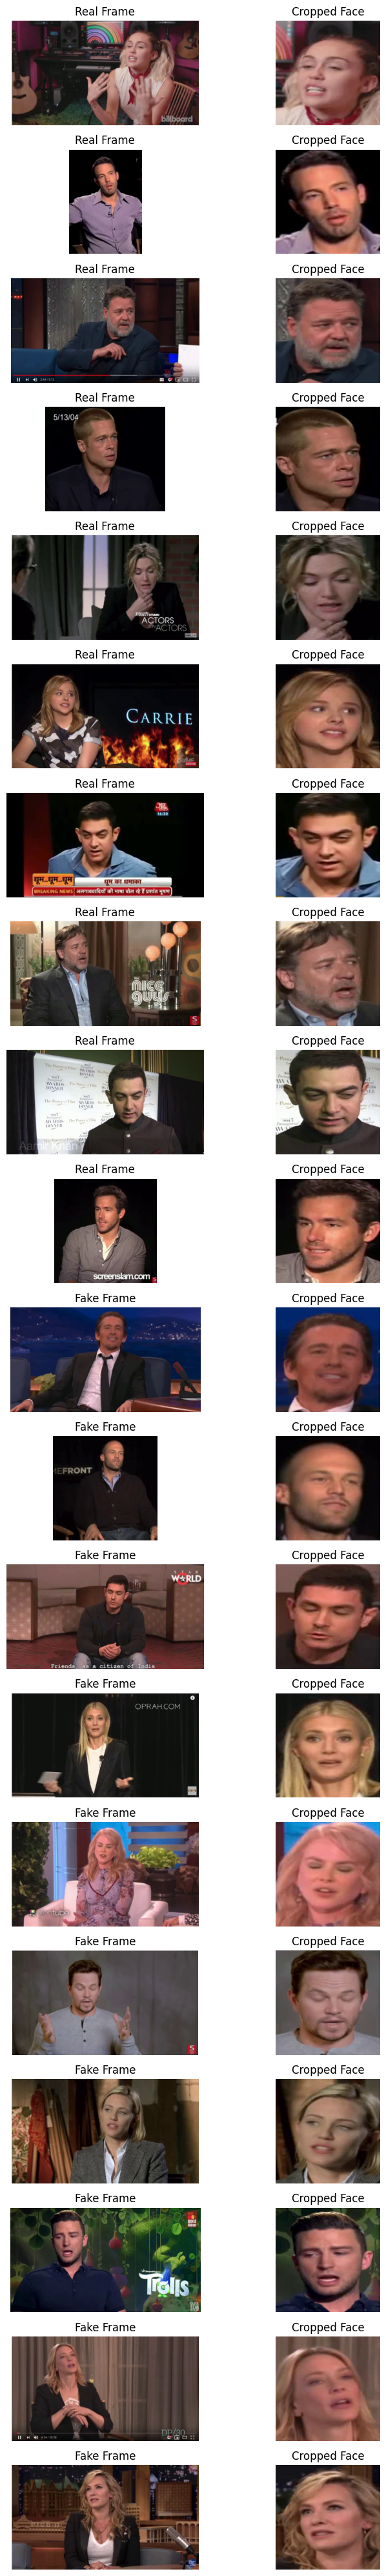

In [2]:
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import torch

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FRAME_EVERY_N = 10
FACE_MARGIN = 0.3
IMG_SIZE = 224
SAMPLE_COUNT = 10

# Init MTCNN
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Helper for cropping with margin
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)
    return image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))

# Sample videos
real_videos = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))[:SAMPLE_COUNT]
fake_videos = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))[:SAMPLE_COUNT]
all_videos = [(v, "Real") for v in real_videos] + [(v, "Fake") for v in fake_videos]

# Visualization
fig, axs = plt.subplots(len(all_videos), 2, figsize=(8, len(all_videos) * 2))
for i, (video_path, label) in enumerate(all_videos):
    cap = cv2.VideoCapture(str(video_path))
    frame, pil_img, face = None, None, None
    video_name = video_path.stem

    # Read the first valid frame
    frame_num = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)
            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], FACE_MARGIN)
                except:
                    pass
            break
        frame_num += 1
    cap.release()

    # Plot frame and face
    axs[i, 0].imshow(pil_img)
    axs[i, 0].set_title(f"{label} Frame")
    axs[i, 0].axis("off")

    if face:
        axs[i, 1].imshow(face)
        axs[i, 1].set_title("Cropped Face")
    else:
        axs[i, 1].text(0.5, 0.5, "No face detected", ha='center', va='center')
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from facenet_pytorch import MTCNN
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FRAMES_DIR = "/kaggle/working/frames"
FACES_DIR = "/kaggle/working/face_data"
PROGRESS_FILE = "/kaggle/working/processed.txt"
SAVE_FRAMES = False  # ⚠️ Only saving face crops
FRAME_EVERY_N = 10
IMG_SIZE = 224
FACE_MARGIN = 0.3
BATCH_SIZE = 6500 # Or max possible

# Init face detector
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Make output folders
for label in ['real', 'fake']:
    os.makedirs(f"{FRAMES_DIR}/{label}", exist_ok=True)
    os.makedirs(f"{FACES_DIR}/{label}", exist_ok=True)

# Load processed video log
if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE) as f:
        processed = set(line.strip() for line in f)
else:
    processed = set()

# Helper to crop face with margin
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)
    return image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))

# Process single video
def process_video(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    frame_num, saved = 0, 0
    video_name = video_path.stem

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)
            frame_filename = f"{video_name}_frame{frame_num:03d}.jpg"

            if SAVE_FRAMES:
                pil_img.save(os.path.join(FRAMES_DIR, label, frame_filename))

            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], FACE_MARGIN)
                    face.save(os.path.join(FACES_DIR, label, frame_filename))
                    saved += 1
                except:
                    pass
        frame_num += 1
    cap.release()
    return saved

# List all videos
real_all = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))
fake_all = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))

# Filter unprocessed videos
real_videos = [v for v in real_all if v.name not in processed][:BATCH_SIZE]
fake_videos = [v for v in fake_all if v.name not in processed][:BATCH_SIZE]

print(f"🧹 Already processed: {len(processed)}")
print(f"🎯 This batch: {len(real_videos)} real, {len(fake_videos)} fake\n")

# Process real videos
for video in tqdm(real_videos, desc="🟢 Real"):
    saved = process_video(video, "real")
    with open(PROGRESS_FILE, "a") as f:
        f.write(video.name + "\n")
    tqdm.write(f"✅ Saved {saved} face crops from {video.name}")

# Process fake videos
for video in tqdm(fake_videos, desc="🔴 Fake"):
    saved = process_video(video, "fake")
    with open(PROGRESS_FILE, "a") as f:
        f.write(video.name + "\n")
    tqdm.write(f"✅ Saved {saved} face crops from {video.name}")

print("\n✅ BATCH COMPLETE")

# ✅ Auto-zip the final cropped faces
print("📦 Zipping cropped face dataset for download...")
!zip -r /kaggle/working/face_data_all.zip /kaggle/working/face_data > /dev/null
print("✅ Done: face_data_all.zip is ready for download.")


In [ ]:
from IPython.display import FileLink

print("✅ ZIP complete. Click the link below to download the file when you're back:")

# Creates clickable download link for face_data_all.zip
display(FileLink("/kaggle/working/face_data_all.zip"))


In [7]:
from facenet_pytorch import MTCNN
import cv2
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch
import zipfile

# CONFIG
DATASET_PATH = "/kaggle/input/deepfake-celebdf"
FACES_DIR = "/kaggle/working/face_data"
PROGRESS_FILE = "/kaggle/working/processed.txt"
BATCH_INDEX_FILE = "/kaggle/working/batch_index.txt"
SAVE_FRAMES = False  # Only saving face crops
FRAME_EVERY_N = 10
IMG_SIZE = 224
FACE_MARGIN = 0.3
REAL_PER_BATCH = 1050
FAKE_PER_BATCH = 2

# Init MTCNN
mtcnn = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Create output dirs
for label in ['real', 'fake']:
    os.makedirs(f"{FACES_DIR}/{label}", exist_ok=True)

# Load processed videos
if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE) as f:
        processed = set(line.strip() for line in f)
else:
    processed = set()

# Load batch index
if os.path.exists(BATCH_INDEX_FILE):
    with open(BATCH_INDEX_FILE) as f:
        batch_index = int(f.read().strip())
else:
    batch_index = 1

# Helper: Crop face with margin
def crop_face_with_margin(image, box, margin=0.3):
    w, h = image.size
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    x1 = max(int(x1 - width * margin), 0)
    y1 = max(int(y1 - height * margin), 0)
    x2 = min(int(x2 + width * margin), w)
    y2 = min(int(y2 + height * margin), h)
    return image.crop((x1, y1, x2, y2)).resize((IMG_SIZE, IMG_SIZE))

# Process one video
def process_video(video_path, label):
    cap = cv2.VideoCapture(str(video_path))
    frame_num, saved = 0, 0
    video_name = video_path.stem

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_num % FRAME_EVERY_N == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(frame_rgb)
            frame_filename = f"{video_name}_frame{frame_num:03d}.jpg"

            boxes, _ = mtcnn.detect(pil_img)
            if boxes is not None:
                try:
                    face = crop_face_with_margin(pil_img, boxes[0], FACE_MARGIN)
                    face.save(os.path.join(FACES_DIR, label, frame_filename))
                    saved += 1
                except:
                    pass
        frame_num += 1
    cap.release()
    return saved

# List all videos
real_all = list(Path(f"{DATASET_PATH}/Celeb-real").glob("*.mp4"))
fake_all = list(Path(f"{DATASET_PATH}/Celeb-synthesis").glob("*.mp4"))

# Filter unprocessed
real_videos = [v for v in real_all if v.name not in processed][:REAL_PER_BATCH]
fake_videos = [v for v in fake_all if v.name not in processed][:FAKE_PER_BATCH]

print(f"🧹 Already processed: {len(processed)}")
print(f"🎯 Processing batch #{batch_index} — {len(real_videos)} real, {len(fake_videos)} fake\n")

# Process real
for video in tqdm(real_videos, desc="🟢 Real"):
    saved = process_video(video, "real")
    with open(PROGRESS_FILE, "a") as f:
        f.write(video.name + "\n")
    tqdm.write(f"✅ Saved {saved} faces from {video.name}")

# Process fake
for video in tqdm(fake_videos, desc="🔴 Fake"):
    saved = process_video(video, "fake")
    with open(PROGRESS_FILE, "a") as f:
        f.write(video.name + "\n")
    tqdm.write(f"✅ Saved {saved} faces from {video.name}")

print(f"\n✅ Batch {batch_index} complete — starting ZIP...")

# Create zip
zip_filename = f"/kaggle/working/face_data_batch_{batch_index}.zip"
!zip -r $zip_filename $FACES_DIR > /dev/null

print(f"📦 Saved ZIP: face_data_batch_{batch_index}.zip")

# Clear face_data to save memory
!rm -rf /kaggle/working/face_data/*
print("🧹 Cleaned up face_data/ to prepare for next batch")

# Save next batch index
with open(BATCH_INDEX_FILE, "w") as f:
    f.write(str(batch_index + 1))

print("✅ Ready for next batch. Just rerun this cell again.")


🧹 Already processed: 6229
🎯 Processing batch #4 — 0 real, 0 fake



🟢 Real: 0it [00:00, ?it/s]
🔴 Fake: 0it [00:00, ?it/s]


✅ Batch 4 complete — starting ZIP...
📦 Saved ZIP: face_data_batch_4.zip


🧹 Cleaned up face_data/ to prepare for next batch
✅ Ready for next batch. Just rerun this cell again.


In [5]:
from pathlib import Path

DATASET_PATH = "/kaggle/input/deepfake-celebdf"

subfolders = ["Celeb-real", "Celeb-synthesis", "YouTube-real"]

print("🎬 Number of videos in each subfolder:\n")
for folder in subfolders:
    video_count = len(list(Path(f"{DATASET_PATH}/{folder}").glob("*.mp4")))
    print(f"📁 {folder}: {video_count} videos")


🎬 Number of videos in each subfolder:

📁 Celeb-real: 590 videos
📁 Celeb-synthesis: 5639 videos
📁 YouTube-real: 300 videos
